In [10]:
import sys
sys.path.append('/home/samuel.varga/python_packages/wofs_ml_severe')
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/mlw2w')
sys.path.append('/home/samuel.varga/python_packages/WoF_post')
sys.path.append('/home/samuel.varga/python_packages/MontePython/')
from ml_2to6_data_pipeline import GridPointExtracter, get_files
from wofs.post.utils import save_dataset, load_multiple_nc_files
#from wofs_ML_2to6_op_pipeline import wofs_ml_2to6
from os.path import join, exists
from glob import glob 
import pandas as pd
import numpy as np
import joblib
import netCDF4
import xarray
from scipy.ndimage import gaussian_filter
from wofs.common import remove_reserved_keys
from wofs.common.zarr import open_dataset

In [26]:
class wofs_ml_2to6:
    '''
    Last Updated: 2024.2.12
    ---------------------------------------------------
    Pipeline class for WoFS ML for 2-6 hr Lead Times.
        - Creates predictors from WoFS Forecast fields
        - Saves predictors to target directory (optional)
        - produces ML output for specified hazards
        - Creates output for multiple predictor scales (optional)
        - Saves ML output as NetCDF to target directory
    ---------------------------------------------------
    Init Arguments:
    ncfiles - list - List of ALL forecast output files. Can be of length 53, 49, or 73, but should be ordered
    outdir - pathlike - directory to save ML output.
    ml_dir - pathlike - directory of ML models.
    model_dics - list - list of dictionaries containing info about ML models - See function load_ml_model
    baseline_dir - pathlike - directory of BL models. If None, BL predictions will not be created.
    out_file - string - filename to save the output netCDF file. Will be joined with ml_dir to create path.
    save_predictors - Bool - If true, saves predictors as nc file in outdir.
    ml_config - Dict. - defines variables to use as predictors. Leave as None to use default set.
    init_time - str - Forecast initialization time as HHmm - Will attempt to parse from files if left as None
    verbose - int - If 1, prints basic debug information. If > 1, prints additional debug information.
    ---------------------------------------------------
    Output:
        Returns None if verbose == 0, else returns X, X_bl, metadata, ml_preds, bl_preds
    ---------------------------------------------------
    '''
    
    
    def __init__(self, ncfiles, ml_dir, outdir, 
                 model_dics=None, baseline_dir=None, save_predictors=False, ml_config=None, 
                 init_time=False, out_file=None, verbose=False, **kwargs):
        self.forecast_files = ncfiles
        self.out_directory = outdir
        
        self.model_directory = ml_dir
        self.save_pred = save_predictors
        self.verbose = verbose
        self.baseline_directory = baseline_dir 
        
        if init_time:
            self.init_time = init_time
        else:
            self.init_time = None
        
        if out_file:
            self.filename = out_file
        else:
            self.filename = None
            
        #Define Forecast Fields to Use as Predictors
        if ml_config:
            self.ml_vars= ml_config
        else:
            self.ml_vars= { 'ENS_VARS':  ['uh_2to5_instant',
                            'uh_0to2_instant',
                            'wz_0to2_instant',
                            'comp_dz',
                            'ws_80',
                            'hailcast',
                            'w_up',
                            'okubo_weiss',
                    ],
             
              'ENV_VARS' : ['mid_level_lapse_rate', 
                            'low_level_lapse_rate', 
                           ],
             
              'SVR_VARS': ['shear_u_0to1', 
                        'shear_v_0to1', 
                        'shear_u_0to6', 
                        'shear_v_0to6',
                        'shear_u_3to6', 
                        'shear_v_3to6',
                        'srh_0to3',
                        'cape_ml', 
                        'cin_ml', 
                        'stp',
                        'scp',
                       ]
            }
        
        #Optimized NMEP Values for the Baseline Models
        self.bl_columns={'hail_severe' :  'hailcast__nmep_>1_25_45km',
          'wind_severe' : 'ws_80__nmep_>50_45km',
          'tornado_severe' : 'uh_2to5_instant__nmep_>200_45km',
            'all_severe' : 'uh_2to5_instant__nmep_>125_45km'}
        
        if model_dics:
            self.model_dics = model_dics
        else:
            self.model_dics = [{'name':'hist','prefix':'sfe','train':'all','hazard':'all','target':'36km','suffix':'control','severity':'Sev'},
             {'name':'hist','prefix':'sfe','train':'all','hazard':'wind','target':'36km','suffix':'control','severity':'Sev'},
             {'name':'hist','prefix':'sfe','train':'all','hazard':'hail','target':'36km','suffix':'control','severity':'Sev'},
             {'name':'hist','prefix':'sfe','train':'all','hazard':'tornado','target':'36km','suffix':'control','severity':'Sev'}]
        
        #Optional kwarg to turn off isotonic regression
        if 'no_calibration' in kwargs.keys() and kwargs['no_calibration']==True:
            print('Using raw ML output') if self.verbose>=1 else None
            self.no_ir = True
        else:
            self.no_ir = False
            
        #Smoothing Parameters
        if 'smoothing' in kwargs.keys():
            #Smoothing can be None or a tuple of shape (smoothing_function, size)
            self.smoothing = kwargs['smoothing']
        else:
            #Default to a guassian_filter with sigma=1
            self.smoothing = (gaussian_filter, 1) 
        
    def load_dataset(self, files):
        """Loads the forecast files into expected format"""
        
        coord_vars = ["xlat", "xlon", "hgt"]
        
        if self.verbose:
            print(f'No. of files: {len(files)}')
            print(f'First file: {files[0]}')
            print(f'Last file: {files[-1]}')
        
        #Check to make sure that only timesteps 24-72 are included
        if len(files) == 53:
            print(f"Input files are of length 53 instead of 49, dropping files 0-3") if self.verbose else None
            files.sort()
            files = files[4:] 
        elif len(files)==49:
            pass
        elif len(files) ==73:
            print(f"Input files are of length 73 instead of 49, dropping files 0-23") if self.verbose else None
            files.sort()
            files = files[24:]
            
        else:
            print(f'Input files are of unrecognized length {len(files)}')
            
        print(f'Final input files are of length {len(files)}') if self.verbose else None
        
        X_strm, coords, _, _  = load_multiple_nc_files(
                files, concat_dim="time", coord_vars=coord_vars,  load_vars=self.ml_vars['ENS_VARS'])

        X_env, _, _, _  = load_multiple_nc_files(
                files, concat_dim="time", coord_vars=coord_vars,  load_vars=self.ml_vars['ENV_VARS'])

        X_svr, _, _, _ = load_multiple_nc_files(
                files, concat_dim="time", coord_vars=coord_vars,  load_vars=self.ml_vars['SVR_VARS'])

        X_env = {**X_env, **X_svr}

        X_env = {v : X_env[v][1] for v in X_env.keys()}
        X_strm = {v : X_strm[v][1] for v in X_strm.keys()}

        ll_grid = (coords['xlat'][1].values, coords['xlon'][1].values)
        
        
        #Update object attributes for later
        self.lats = coords['xlat'][1][::3, ::3]
        self.lons = coords['xlon'][1][::3, ::3]
        if self.filename is None:
            self.filename = files[0].split('/')[-1].split('_')
            self.filename = f"{self.filename[0]}_ML2TO6_{'_'.join(self.filename[3:])}"
            # Need to save as a netcdf file
            self.filename = self.filename.replace('.json', '.nc')                               
        if self.init_time is None:
            self.init_time = files[0].split('/')[-1].split('_')[-2]
    
        return X_env, X_strm, files[0], ll_grid
    
    def load_predictors(self):
        '''Loads the files and creates the ML predictors'''
        #Load the Data
        print('Loading Dataset') if self.verbose else None
        X_env, X_strm, ncfile, llgrid  = self.load_dataset(self.forecast_files)
        
        
        self.forecast_shape = np.shape(llgrid[0][::3, ::3])
        print(f'Forecast Shape: {self.forecast_shape}') if self.verbose else None

        #Create Predictors
        
        print('Creating Predictors') if self.verbose else None
        extracter = GridPointExtracter(ncfile, env_vars=X_env.keys(), strm_vars=X_strm.keys(), ll_grid=llgrid)
        df = extracter(X_env, X_strm, predict=True) 
        df.reset_index(drop=True, inplace=True)

        #Convert to Predictor Format
        metadata = ['Run Date', 'Init Time']#,'NX','NY']
        bl_columns = [b for b in self.bl_columns.values()] if self.baseline_directory else []
        ml_features = [f for f in df.columns if f not in metadata]
        ml_features = [f for f in ml_features if 'nmep' not in f.lower()]
        
        if self.verbose >1:
            print(f'Metadata Columns: {metadata}')
            print(f'BL Columns: {bl_columns}')
            print(f'ML Columns: {ml_features}')
        
        #Separate into different variables
        print('Separating Datasets') if self.verbose else None
        X = df[ml_features]
        X_bl = df[bl_columns] 
        meta = df[metadata]
        
        return X, X_bl, meta
    
    def load_predictor_scales(self, X, training_scale=None, category=None):
        '''Takes input dataframe X and removes columns that contain predictors
        of a size (category) different than training_scale (category)
        ------------------------------------------------------------------
        Arguments:
        X - input dataframe created by self.load_predictors
        training_scale - str/float/int - Only predictors of this scale are kept. Can be any of [None, 9, 27, 45]
        category - str - only predictors of this category are kept. Can be any of [None, 'intrastorm', 'environmental']
        ------------------------------------------------------------------
        Returns:
        X - dataframe with n_columns <= Input X
        ts_suff - str - training-scale suffix denoting which predictor scales are being used
        var_sufs - str - variable suffix denoting which predictor types are being used'''
    

        #Ensure that NX, NY are not in predictor set (Redundancy check)
        X=X[[col for col in X.columns if col not in ['NX','NY']]]

        #Remove all columns except for those with correct spatial scale 
        if training_scale and str(training_scale).lower() !='all': 
            print(f'Dropping all variables except {training_scale} fields') if self.verbose else None
            X=X[[col for col in X.columns if training_scale in col]] 
        ts_suff= training_scale 

        #Remove all columns except for those with correct variable type (Storm/Env)
        if category and category.lower() !='control': 
            #Create a list of every column with a storm variable
            for storm_var in self.ml_vars['ENS_VARS']:        
                storm_columns =[col for col in X.columns if stormvar in col] 

            print(f'Dropping all {category} variables') if self.verbose else None
            X = X[storm_columns] if 'storm' in category.lower() else X.drop(storm_columns, axis=1)

        var_suff = category if category else 'control'    
        
        print(f'Variable Suffix: {var_suff}') if self.verbose else None
        print(f'Training Scale: {ts_suff}') if self.verbose else None
        
        return X
    
    def load_ml_model(self, kwarg_dic):
        '''Load naming Parameters based on dict. input
            ------------------------------------------
            Input: kwarg_dic - dictionary with any of the following k:v pairs:
        '''
        name=kwarg_dic.get('name', 'hist')
        prefix=kwarg_dic.get('prefix', 'sfe_prep')
        train_scale=kwarg_dic.get('train', 'all')
        hazard_name=kwarg_dic.get('hazard', 'all')
        targ_scale=kwarg_dic.get('target', '36km')
        suffix=kwarg_dic.get('suffix', 'control')
        severity = kwarg_dic.get('severity','Sev')
        calibration = False if self.no_ir else kwarg_dic.get('calibration',True)
        
        if self.verbose >1:
            print(f'Loading {prefix}_{train_scale}_{name}_{hazard_name}_{targ_scale}_{severity}_{suffix}_0.joblib')
        
        ml_data=joblib.load(join(self.model_directory,f'{prefix}_{train_scale}_{name}_{hazard_name}_{targ_scale}_{severity}_{suffix}_0.joblib'))
        
        out_dic={'model':(name, ml_data['model']), 'suffix':suffix, 'target':targ_scale, 'severity':severity,
                 'hazard':hazard_name, 'train':train_scale, 'prefix':prefix, 'name':name, 
                 'features':ml_data['X'].columns, 'calibration':calibration}

        return out_dic
    
    def get_bl_pred(self, X_bl):
        '''Loads BL Model and Predicts on X_bl, then reshapes into self.forecast_shape'''

        bl_preds = {}

        print('Getting BL Predictions') if self.verbose else None

        for bl in self.bl_columns.keys():
            bl_model = joblib.load(join(self.baseline_directory, f'{bl.split("_")[0]}_baseline_model_36km.joblib'))
            bl_pred_2D = bl_model.predict(X_bl[self.bl_columns[bl]]).reshape(self.forecast_shape)
            bl_preds[f'{bl}_baseline'] = (['lat','lon'], bl_pred_2D)

        return bl_preds
    
    def get_ml_pred(self, X, model_dic): 
        '''Takes loaded ML model and predicts on X, then reshapes into self.forecast_shape'''
        #Reorganize features to be in correct order
        
        ml_model = model_dic['model'][1]
        features = model_dic['features']
        X = X[features]
        
        #Make predictions and reshape
        if self.no_ir or model_dic['calibration'] == False:
            X = ml_model.calibrated_classifiers_[0].base_estimator.named_steps['scaler'].transform(X)
            ml_pred = ml_model.calibrated_classifiers_[0].base_estimator.named_steps['model'].predict_proba(X)[:,1]
        else:          
            ml_pred = ml_model.predict_proba(X)[:,1]  
        
        ml_pred_2D = ml_pred.reshape(self.forecast_shape)
        return ml_pred_2D
    
    def get_predictions(self, X, X_baseline):
        '''Create ML and BL Predictions'''
        
        print('Creating Predictions') if self.verbose else None
        #ML Predictions
        ml_preds = {}
        for ml_dic in self.model_dics:
            ml_model = self.load_ml_model(ml_dic)  
            ml_name = f'{ml_model["severity"]}_{ml_model["hazard"]}_predictor_scale_{ml_model["train"]}_predictor_type_{ml_model["suffix"]}'
            
            #Unsmoothed predictions
            ml_preds[f'{ml_name}_unsmoothed'] = (['lat','lon'], 
                                 self.get_ml_pred(self.load_predictor_scales(X, ml_model['train'], ml_model['suffix']), ml_model))
            #Smoothed predictions
            if self.smoothing: 
                ml_preds[ml_name] = (['lat','lon'], 
                                     self.smoothing[0](self.get_ml_pred(self.load_predictor_scales(X, ml_model['train'], ml_model['suffix']), ml_model), self.smoothing[1]))

        #BL Predictions
        if self.baseline_directory:
            bl_preds = self.get_bl_pred(X_baseline)
        else:
            bl_preds = {}
        
        return ml_preds, bl_preds
    
    def save_ml_predictions(self, ml, bl):
        '''Saves the predictions as an NC file in self.out_directory'''

        ds = xarray.Dataset({**ml, **bl, 'xlat':self.lats, 'xlon':self.lons})
        
        fname = join(self.out_directory, self.filename)
        print("\n\n\n")
        print(f"{fname=}")        
        wofs_ds = open_dataset(self.forecast_files[0])

        # cleanup reserved netcdf keys
        for attr, val in wofs_ds.attrs.items():
            ds.attrs[attr] = val 

        for var in ds.data_vars:
            ds.data_vars[var].attrs = remove_reserved_keys(ds.data_vars[var].attrs)
    
        ds.attrs = remove_reserved_keys(ds.attrs)
        
        ds.to_netcdf(fname)
        ds.close()
        print(f'file saved at {fname}') if self.verbose else None

        return fname
    
    def save_predictors(self, X, X_bl, meta):
        '''Saves the predictors and metadata as a dataframe in self.out_directory'''
        df = pd.concat([X, X_bl, meta], axis=1)
        name_split = self.filename.split('ML2TO6')
        out_name = f"{name_split[0]}ML2TO6_PREDICTORS{name_split[1]}"
        df.to_feather(join(self.out_directory, out_name))

        print(f'Saving predictors at {join(self.out_directory, out_name)}') if self.verbose else None
        
        return None
    
    def run_pipeline(self):
        print(f'Running pipeline for {self.init_time}') if self.verbose else None
                               
        #Load forecast files and create predictors
        X, X_bl, meta = self.load_predictors()
        
        #Get ML and BL predictions
        ml_preds, bl_preds = self.get_predictions(X, X_bl)
            
        fname = self.save_ml_predictions(ml_preds, bl_preds)

        if self.save_pred:
            self.save_predictors(X, X_bl, meta)
        
        return fname

# Usage

In [12]:
files=get_files('/work/mflora/SummaryFiles/20230523_d1/0000/')[0]
ml_dir = '/work/samuel.varga/projects/2to6_hr_severe_wx/sfe_prep/stripped_models/'
bl_dir = '/work/samuel.varga/projects/2to6_hr_severe_wx/sfe_prep/blModels/'
model_dics = [{'name':'hist','prefix':'sfe','train':'all','hazard':'all','target':'36km','suffix':'control','severity':'Sev'},
             {'name':'hist','prefix':'sfe','train':'all','hazard':'wind','target':'36km','suffix':'control','severity':'Sev'},
             {'name':'hist','prefix':'sfe','train':'all','hazard':'hail','target':'36km','suffix':'control','severity':'Sev'},
             {'name':'hist','prefix':'sfe','train':'all','hazard':'tornado','target':'36km','suffix':'control','severity':'Sev'},]

In [28]:
obj = wofs_ml_2to6(files, ml_dir, '.', model_dics=model_dics, verbose=1, baseline_dir = None, save_predictors=False)
fname = obj.run_pipeline()

Running pipeline for None
Loading Dataset
No. of files: 49
First file: /work/mflora/SummaryFiles/20230523_d1/0000/wofs_ALL_24_20230524_0000_0200.nc
Last file: /work/mflora/SummaryFiles/20230523_d1/0000/wofs_ALL_72_20230524_0000_0600.nc
Final input files are of length 49
Forecast Shape: (100, 100)
Creating Predictors
Separating Datasets
Creating Predictions
Variable Suffix: control
Training Scale: all
Variable Suffix: control
Training Scale: all
Variable Suffix: control
Training Scale: all
Variable Suffix: control
Training Scale: all
Variable Suffix: control
Training Scale: all
Variable Suffix: control
Training Scale: all
Variable Suffix: control
Training Scale: all
Variable Suffix: control
Training Scale: all




fname='./wofs_ML2TO6_20230524_0000_0200.nc'
file saved at ./wofs_ML2TO6_20230524_0000_0200.nc


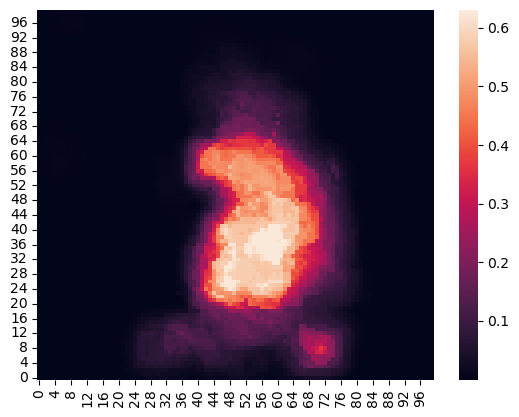

In [29]:
%matplotlib inline
import xarray
import matplotlib.pyplot as plt
import seaborn
ds = xarray.load_dataset('wofs_ML2TO6_20230524_0000_0200.nc')
fig, ax =plt.subplots()
seaborn.heatmap(ds['Sev_all_predictor_scale_all_predictor_type_control_unsmoothed'])
ax.invert_yaxis()
plt.show()

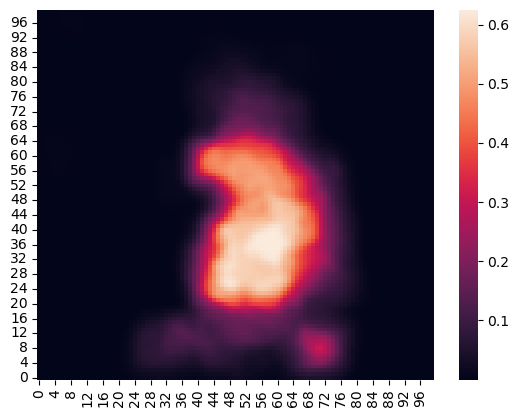

In [30]:
ds = xarray.load_dataset('wofs_ML2TO6_20230524_0000_0200.nc')
fig, ax =plt.subplots()
seaborn.heatmap(ds['Sev_all_predictor_scale_all_predictor_type_control'])
ax.invert_yaxis()